# TimescaleDB Analysis

SQL-based analysis of Hyperliquid fill data stored in TimescaleDB.

**Prerequisites:**
```bash
just up                    # Start TimescaleDB
just fetch 2025-11-01      # Fetch data to parquet
just load                  # Load parquet into DB
```

---

## Setup

In [1]:
import pandas as pd

from vigil.db import execute_query

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.float_format", "{:,.2f}".format)


def query(sql: str) -> pd.DataFrame:
    """Execute SQL and return DataFrame."""
    df = execute_query(sql)
    return df.to_pandas()


print("Connected to database")

Connected to database


---

## Data Overview

In [2]:
# Quick stats
query("""
SELECT 
    COUNT(*) AS total_fills,
    COUNT(*) / 2 AS total_trades,
    COUNT(DISTINCT user_address) AS unique_traders,
    COUNT(DISTINCT coin) AS unique_coins,
    SUM(px::numeric * sz::numeric) / 2 AS total_volume,
    MIN(time) AS first_fill,
    MAX(time) AS last_fill
FROM fills
""")

,total_fills,total_trades,unique_traders,unique_coins,total_volume,first_fill,last_fill
0,4462166,2231083,29975,289,5865937566.3858625199999099,1753606210273,1753660799902


In [3]:
# Data by day (time is in ms, so divide by 86400000 for days)
query("""
SELECT 
    (time / 86400000) * 86400000 AS day,
    COUNT(*) / 2 AS trades,
    COUNT(DISTINCT user_address) AS traders,
    SUM(px::numeric * sz::numeric) / 2 AS volume
FROM fills
GROUP BY day
ORDER BY day
""")

,day,trades,traders,volume
0,1753574400000,2231083,29975,5865937566.3858625199999099


---

## Top Traders by Volume

In [4]:
query("""
SELECT 
    user_address,
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    COUNT(DISTINCT coin) AS coins_traded
FROM fills
GROUP BY user_address
ORDER BY volume DESC
LIMIT 20
""")

,user_address,trades,volume,coins_traded
0,0xe3b6e3443c8f2080704e7421bad9340f13950acb,8523,233151428.813710000000,1
1,0x57dd78cd36e76e2011e8f6dc25cabbaba994494b,24333,200092603.483638500000,49
2,0xc6ac58a7a63339898aeda32499a8238a46d88e84,7024,166014047.906295000000,1
3,0x162cc7c861ebd0c06b3d72319201150482518185,50976,122116497.696925780000,17
4,0xf9109ada2f73c62e9889b45453065f0d99260a2d,22848,121544488.593271150000,33
5,0xecb63caa47c7c4e77f60f1ce858cf28dc2b82b00,40854,86966853.664554600000,52
6,0xd911e53d53b663972254e086450fd6198a25961e,1726,86207247.963535000000,1
7,0xf3e16a28b09be3836e66f091613c230128141fc1,4580,81903654.100830000000,4
8,0x023a3d058020fb76cca98f01b3c48c8938a22355,19787,79534594.910401000000,65
9,0x8e80c4b533dd977cf716b5c24fd9223129272804,5177,71031406.399581000000,18


---

## Top Traders by PnL

In [5]:
# Top winners
query("""
SELECT 
    user_address,
    SUM(closed_pnl::numeric) AS realized_pnl,
    SUM(fee::numeric) AS fees_paid,
    SUM(closed_pnl::numeric) - SUM(fee::numeric) AS net_pnl,
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume
FROM fills
GROUP BY user_address
HAVING SUM(closed_pnl::numeric) > 0
ORDER BY net_pnl DESC
LIMIT 20
""")

,user_address,realized_pnl,fees_paid,net_pnl,trades,volume
0,0x66362b929c1a9aaf14c51aab9b455ad7fb8268c4,1006389.6314610000,16472.913431000,989916.7180300000,2391,40440277.846192500000
1,0xfdcec78b3a783d677bad7b8d58823cea5b5d26c2,968703.2177199999,4742.132942087,963961.0847779129,373,9080293.326220000000
2,0x2ba553d9f990a3b66b03b2dc0d030dfc1c061036,811054.0353169800,7428.278047488,803625.7572694920,3623,18003475.386704100000
3,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,732300.0902100000,2243.452145000,730056.6380650000,719,12031885.063515500000
4,0x34365f472a3af2ff8167970a519931437e2c2094,605744.0191800000,3636.732129000,602107.2870510000,433,8107811.169685500000
5,0xc08b122fb1057149f55d49d3d5cea0d083b37ffb,517182.0708740000,251.620865000,516930.4500090000,1315,298441.057707000000
6,0x7e5f834c167a90e3419849074160ff71b8f30185,515187.7822763300,206.075159680,514981.7071166500,39,257593.949600000000
7,0x1a67ea21ba0f895560590147203d08a832054055,470845.0145079999,12457.892255000,458387.1222529999,380,22246236.859945000000
8,0x15271757b398cd1d3d7cca05c4f7b0c159afa7c2,436728.9272260000,978.795176000,435750.1320500000,992,2833565.948550000000
9,0x75d415edcb3c3782e5952470821e983f9053a209,409746.6090140000,4442.464551000,405304.1444630000,223,5553081.223915000000


In [6]:
# Top losers
query("""
SELECT 
    user_address,
    SUM(closed_pnl::numeric) AS realized_pnl,
    SUM(fee::numeric) AS fees_paid,
    SUM(closed_pnl::numeric) - SUM(fee::numeric) AS net_pnl,
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume
FROM fills
GROUP BY user_address
HAVING SUM(closed_pnl::numeric) < 0
ORDER BY net_pnl ASC
LIMIT 20
""")

,user_address,realized_pnl,fees_paid,net_pnl,trades,volume
0,0x985f02b19dbc062e565c981aac5614baf2cf501f,-2297474.2373770000,3358.5677740000,-2300832.8051510000,2415,6904034.057205000000
1,0xecb63caa47c7c4e77f60f1ce858cf28dc2b82b00,-1399932.2316466100,-9921.1507089200,-1390011.0809376900,40854,86966853.664554600000
2,0xa6e2dc44418f5ad213c86db4dbb203a59d13c49f,-723130.4427920000,2877.8755010000,-726008.3182930000,4296,8293386.583098500000
3,0x875d24a727a186bd73d87cc8851f5b4526f70d09,-559743.7227770000,32326.9311420000,-592070.6539190000,1973,53878221.977343000000
4,0xa31441e058492bc7cfffda9aa7623c407ae83a81,-555058.6433270000,1025.3155480000,-556083.9588750000,1725,2847703.933941000000
5,0x023a3d058020fb76cca98f01b3c48c8938a22355,-496071.4069390000,-4668.2033122900,-491403.2036267100,19787,79534594.910401000000
6,0x7717a7a245d9f950e586822b8c9b46863ed7bd7e,-472950.9938870000,275.1090820000,-473226.1029690000,27095,30552047.054831000000
7,0x5f7e1de048ba1f23f60b1455849eebfce4a6b441,-415824.8059850000,2804.5537080000,-418629.3596930000,720,3505692.930165000000
8,0x8d561a78bff637971c20c2640653eac790707480,-334843.0000000000,1152.5662080000,-335995.5662080000,35,2091105.500000000000
9,0x319d046ac361ac2fbe89518c62daa42f4073dc82,-277949.7022815500,137.6081159400,-278087.3103974900,39,98694.209760400000


---

## Volume by Coin

In [7]:
query("""
SELECT 
    coin,
    COUNT(*) / 2 AS trades,
    COUNT(DISTINCT user_address) AS unique_traders,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    AVG(px::numeric) AS avg_price
FROM fills
GROUP BY coin
ORDER BY volume DESC
LIMIT 20
""")

,coin,trades,unique_traders,volume,avg_price
0,ETH,184632,7079,2067758962.268200000000,3831.01318947961350150000
1,BTC,148332,6538,1409962363.190990000000,118921.55003640482200000000
2,SOL,86805,3861,425266562.005400000000,187.77056171879500030000
3,HYPE,250658,5942,279343803.706170000000,43.42812460005266140000
4,XRP,48393,1801,249842111.646200000000,3.20979781373339120000
5,ENA,85724,2044,139182897.329080000000,0.64914852538378983715
6,SUI,74097,2157,137096055.984950000000,4.30213228065913600000
7,FARTCOIN,86488,2219,106159687.595820000000,1.34681524951438350000
8,kPEPE,32900,862,86986115.033145000000,0.01271024787234042553
9,@107,106648,2610,78479450.266890000000,43.43429730515340180000


---

## Maker vs Taker Analysis

In [8]:
# Overall maker/taker split
query("""
SELECT 
    CASE WHEN crossed THEN 'Taker' ELSE 'Maker' END AS order_type,
    COUNT(*) AS fills,
    SUM(px::numeric * sz::numeric) AS volume,
    SUM(fee::numeric) AS total_fees,
    AVG(fee::numeric) AS avg_fee
FROM fills
GROUP BY crossed
ORDER BY volume DESC
""")

,order_type,fills,volume,total_fees,avg_fee
0,Maker,2231083,5865937566.3858625199999099,48839.8220639424,0.02189063430806581378
1,Taker,2231083,5865937566.3858625199999099,2545050.6545852966,1.14072432741645950000


In [9]:
# Top makers (provide liquidity)
query("""
SELECT 
    user_address,
    COUNT(*) AS total_fills,
    SUM(CASE WHEN NOT crossed THEN 1 ELSE 0 END) AS maker_fills,
    ROUND(100.0 * SUM(CASE WHEN NOT crossed THEN 1 ELSE 0 END) / COUNT(*), 2) AS maker_pct,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    SUM(closed_pnl::numeric) - SUM(fee::numeric) AS net_pnl
FROM fills
GROUP BY user_address
HAVING COUNT(*) >= 100
ORDER BY maker_pct DESC
LIMIT 20
""")

,user_address,total_fills,maker_fills,maker_pct,volume,net_pnl
0,0x0eb0c04b5a029ba7e2a65d2bb0d3d8df81135844,18045,18045,100.00,5357123.9599850000000000,-60.7710754500
1,0x0dd73d2b71efb30daf8cd48c9dfa8dc35868fe65,313,313,100.00,26133.7215400000000000,-394.8705138500
2,0x0e7d09a53f348fcef8bb139af9ebb552f4a33fe9,549,549,100.00,271112.0045300000000000,16.2264660000
3,0x093f2e026bf3d52f5ba02306976255782ffbf712,2232,2232,100.00,484231.6705350000000000,-68.0828180000
4,0x0b1ace05eb9ef1c3a1951b763700ecad24f27741,3808,3808,100.00,1520524.4191500000000000,-64.5425660000
5,0x0cda69a73f9bbea90e136172eb241bd065977e00,331,331,100.00,1465130.4598750000000000,-13078.5090240000
6,0x0dd5db9c3748486e747c6a123727f472668cf6ee,3359,3359,100.00,365077.7023900000000000,-22.9104280000
7,0x0e0692c58ef0f264319d46cad3f420685c3e52ac,344,344,100.00,2207512.8428300000000000,5703.7562640000
8,0x08ca4981130794fb8e9700186fa7ec689bf2d1c2,311,311,100.00,391857.3004990000000000,-6025.2044440000
9,0x0873ca7cb967af8c35642d903a950d256c1701df,3961,3961,100.00,5967252.5772950000000000,565.3566240000


---

## Win Rate Analysis

In [10]:
# Traders with best win rate (min 10 closing trades)
query("""
SELECT 
    user_address,
    COUNT(*) FILTER (WHERE dir LIKE 'Close%') AS closing_trades,
    COUNT(*) FILTER (WHERE dir LIKE 'Close%' AND closed_pnl::numeric > 0) AS wins,
    COUNT(*) FILTER (WHERE dir LIKE 'Close%' AND closed_pnl::numeric < 0) AS losses,
    ROUND(100.0 * COUNT(*) FILTER (WHERE dir LIKE 'Close%' AND closed_pnl::numeric > 0) / 
        NULLIF(COUNT(*) FILTER (WHERE dir LIKE 'Close%'), 0), 2) AS win_rate,
    SUM(closed_pnl::numeric) AS total_pnl
FROM fills
GROUP BY user_address
HAVING COUNT(*) FILTER (WHERE dir LIKE 'Close%') >= 10
ORDER BY win_rate DESC
LIMIT 20
""")

,user_address,closing_trades,wins,losses,win_rate,total_pnl
0,0x03667fa871ba6ae6b3966c037ce55ba0e1af4e6f,33,33,0,100.00,14660.59530400
1,0x035a6a2c9994f29a68a0d404cfbf529420a2f17c,37,37,0,100.00,30.80288100
2,0x03058ba633758ad50e8c8c628312e42e495c4c16,51,51,0,100.00,1436.49902000
3,0x035c84e918e9fbbded9d4cc57c91a76716fc38fc,16,16,0,100.00,405.59467400
4,0x0329af93f786a123b74ffc2e3f4243ad00dce73a,14,14,0,100.00,359.64968400
5,0x027f3c553beb7261bebba7dc9b951ca5f55cce96,36,36,0,100.00,10968.08729000
6,0x02aaa417b43f9a23e772276c31c5bd7ed9a682bc,22,22,0,100.00,16422.10969000
7,0x02bf19e96f90df65b43830b956db6bb9047ec562,51,51,0,100.00,-8.92338799
8,0x019d4248690664e2a87a4aa2a26f83c8e63de7c4,245,245,0,100.00,21846.08838700
9,0x0041287043b3c221b19eed8fbfb3bc6b3da03ba4,38,38,0,100.00,814.59425200


---

## Hourly Volume (TimescaleDB time_bucket)

In [11]:
# Hourly volume (time is in ms, convert to datetime for plotting)
hourly = query("""
SELECT 
    (time / 3600000) * 3600000 AS hour_ms,
    COUNT(*) / 2 AS trades,
    COUNT(DISTINCT user_address) AS active_traders,
    SUM(px::numeric * sz::numeric) / 2 AS volume
FROM fills
GROUP BY hour_ms
ORDER BY hour_ms
""")

# Convert decimal columns to float for plotting
hourly['volume'] = hourly['volume'].astype(float)

# Convert ms to datetime
hourly['hour'] = pd.to_datetime(hourly['hour_ms'], unit='ms')
print(f"Hourly data: {len(hourly)} hours")
hourly[['hour', 'trades', 'active_traders', 'volume']].head(10)

Hourly data: 16 hours


,hour,trades,active_traders,volume
0,2025-07-27 08:00:00,8759,888,"20,597,819.17"
1,2025-07-27 09:00:00,111974,5634,"219,767,991.26"
2,2025-07-27 10:00:00,129956,5599,"382,977,143.56"
3,2025-07-27 11:00:00,107077,5001,"261,458,872.46"
4,2025-07-27 12:00:00,133307,6701,"405,470,850.85"
5,2025-07-27 13:00:00,128806,6771,"283,420,289.84"
6,2025-07-27 14:00:00,132157,6468,"281,984,723.06"
7,2025-07-27 15:00:00,134763,6796,"345,725,760.54"
8,2025-07-27 16:00:00,259644,11002,"783,266,803.32"
9,2025-07-27 17:00:00,180463,7300,"413,873,140.46"


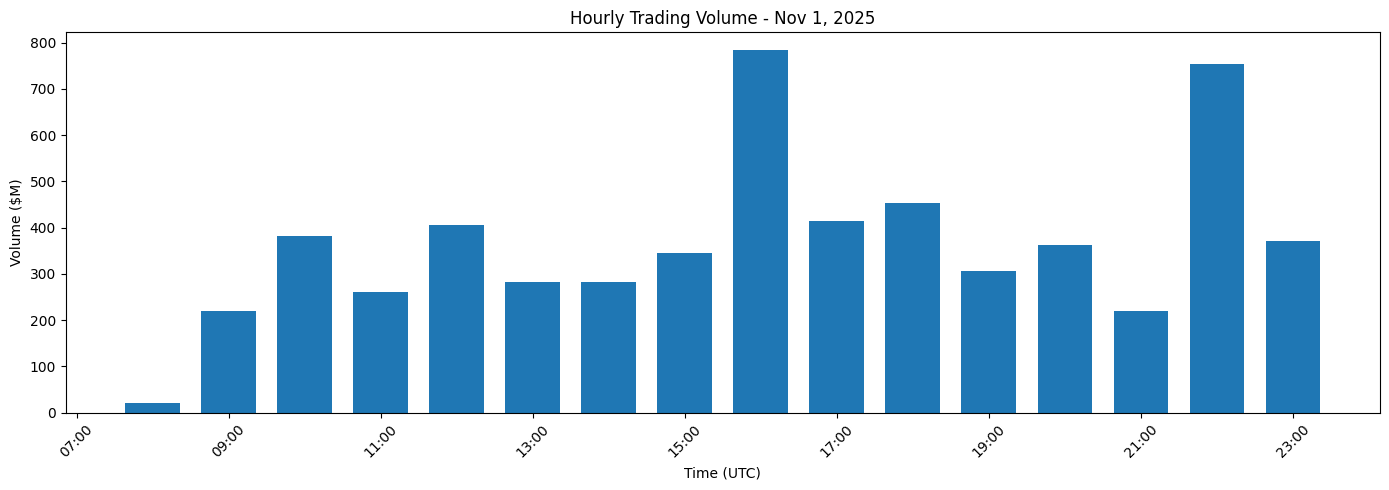

In [12]:
# Plot hourly volume
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(hourly['hour'], hourly['volume'] / 1e6, width=0.03)
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Volume ($M)')
ax.set_title('Hourly Trading Volume - Nov 1, 2025')

# Format x-axis as hours
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## Continuous Aggregate: trader_daily

Pre-computed daily trader stats (faster for large datasets).

In [13]:
# trader_daily is now a regular view, no refresh needed
print("trader_daily is a regular view (computed on query)")

trader_daily is a regular view (computed on query)


In [14]:
# Query the trader_daily view
query("""
SELECT 
    day,
    COUNT(DISTINCT user_address) AS traders,
    SUM(fill_count) / 2 AS total_trades,
    SUM(volume) / 2 AS total_volume,
    SUM(realized_pnl) AS total_pnl,
    SUM(fees_paid) AS total_fees
FROM trader_daily
GROUP BY day
ORDER BY day
""")

,day,traders,total_trades,total_volume,total_pnl,total_fees
0,1753574400000,29975,2231083.000000000000,5865937566.3858625199999099,6822685.8037992108,2593890.4766492390


In [15]:
# Top traders from view
query("""
SELECT 
    user_address,
    SUM(fill_count) / 2 AS trades,
    SUM(volume) / 2 AS volume,
    SUM(realized_pnl) - SUM(fees_paid) AS net_pnl,
    AVG(maker_pct) * 100 AS avg_maker_pct,
    SUM(winning_trades) AS wins,
    SUM(losing_trades) AS losses
FROM trader_daily
GROUP BY user_address
ORDER BY net_pnl DESC
LIMIT 20
""")

,user_address,trades,volume,net_pnl,avg_maker_pct,wins,losses
0,0x66362b929c1a9aaf14c51aab9b455ad7fb8268c4,2391.5000000000000000,40440277.846192500000,989916.7180300000,38.53230190257160777800,2879,994
1,0xfdcec78b3a783d677bad7b8d58823cea5b5d26c2,373.0000000000000000,9080293.326220000000,963961.0847779129,24.93297587131367292200,216,0
2,0x2ba553d9f990a3b66b03b2dc0d030dfc1c061036,3623.0000000000000000,18003475.386704100000,803625.7572694920,5.02346121998343913900,2161,2986
3,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,719.0000000000000000,12031885.063515500000,730056.6380650000,58.41446453407510431200,972,38
4,0x34365f472a3af2ff8167970a519931437e2c2094,433.5000000000000000,8107811.169685500000,602107.2870510000,12.91810841983852364500,419,0
5,0xc08b122fb1057149f55d49d3d5cea0d083b37ffb,1315.0000000000000000,298441.057707000000,516930.4500090000,2.01520912547528517100,2630,0
6,0x7e5f834c167a90e3419849074160ff71b8f30185,39.5000000000000000,257593.949600000000,514981.7071166500,100.00000000000000000000,79,0
7,0x1a67ea21ba0f895560590147203d08a832054055,380.0000000000000000,22246236.859945000000,458387.1222529999,0E-20,481,0
8,0x15271757b398cd1d3d7cca05c4f7b0c159afa7c2,992.5000000000000000,2833565.948550000000,435750.1320500000,54.86146095717884131000,1983,0
9,0x75d415edcb3c3782e5952470821e983f9053a209,223.5000000000000000,5553081.223915000000,405304.1444630000,0E-20,447,0


---

## Trader Deep Dive

Analyze a specific trader's activity.

In [16]:
# Set trader address to analyze
# Find top trader first
top_trader = query("""
SELECT user_address 
FROM fills 
GROUP BY user_address 
ORDER BY SUM(closed_pnl::numeric) DESC 
LIMIT 1
""").iloc[0]['user_address']

TRADER = top_trader
print(f"Analyzing: {TRADER}")

Analyzing: 0x66362b929c1a9aaf14c51aab9b455ad7fb8268c4


In [17]:
# Trader summary
query(f"""
SELECT 
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    COUNT(DISTINCT coin) AS coins_traded,
    SUM(closed_pnl::numeric) AS realized_pnl,
    SUM(fee::numeric) AS fees_paid,
    SUM(closed_pnl::numeric) - SUM(fee::numeric) AS net_pnl,
    ROUND(100.0 * SUM(CASE WHEN NOT crossed THEN 1 ELSE 0 END) / COUNT(*), 2) AS maker_pct,
    MIN(time) AS first_trade,
    MAX(time) AS last_trade
FROM fills
WHERE user_address = '{TRADER}'
""")

,trades,volume,coins_traded,realized_pnl,fees_paid,net_pnl,maker_pct,first_trade,last_trade
0,2391,40440277.846192500000,6,1006389.631461,16472.913431,989916.718030,38.53,1753613532024,1753628976856


In [18]:
# Trader's coin breakdown
query(f"""
SELECT 
    coin,
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    SUM(closed_pnl::numeric) AS pnl
FROM fills
WHERE user_address = '{TRADER}'
GROUP BY coin
ORDER BY volume DESC
LIMIT 10
""")

,coin,trades,volume,pnl
0,BTC,1062,27064931.6734850000000000,374356.876585
1,ETH,163,6302117.1347600000000000,602407.646276
2,SOL,555,5506110.5294000000000000,-15921.113946
3,PENGU,436,993770.6934405000000000,0.000000
4,ARB,174,569239.3214550000000000,45495.886416
5,kPEPE,1,4108.4936520000000000,50.336130


In [19]:
# Trader's hourly activity
query(f"""
SELECT 
    (time / 3600000) * 3600000 AS hour,
    COUNT(*) / 2 AS trades,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    SUM(closed_pnl::numeric) AS pnl
FROM fills
WHERE user_address = '{TRADER}'
GROUP BY hour
ORDER BY hour
""")

,hour,trades,volume,pnl
0,1753610400000,17,72024.406900000000,312.478762
1,1753614000000,615,5632874.846186000000,-911.030660
2,1753617600000,1323,33741607.899666000000,1006988.183359
3,1753621200000,106,256176.207071500000,0.000000
4,1753624800000,208,487594.496465000000,0.000000
5,1753628400000,121,249999.989904000000,0.000000


In [20]:
# Trader's recent fills
query(f"""
SELECT 
    time,
    coin,
    side,
    dir,
    px::numeric AS price,
    sz::numeric AS size,
    px::numeric * sz::numeric AS notional,
    closed_pnl::numeric AS closed_pnl,
    crossed AS is_taker
FROM fills
WHERE user_address = '{TRADER}'
ORDER BY time DESC
LIMIT 20
""")

,time,coin,side,dir,price,size,notional,closed_pnl,is_taker
0,1753628976856,PENGU,B,Open Long,0.042896,56752.0,2434.4337920,0.0,False
1,1753628976856,PENGU,B,Open Long,0.042896,51888.0,2225.7876480,0.0,False
2,1753628976856,PENGU,B,Open Long,0.042896,24326.0,1043.4880960,0.0,False
3,1753628976714,PENGU,B,Open Long,0.042896,9089.0,389.8817440,0.0,False
4,1753628976714,PENGU,B,Open Long,0.042896,9000.0,386.0640000,0.0,False
5,1753628976714,PENGU,B,Open Long,0.042896,57122.0,2450.3053120,0.0,False
6,1753628976714,PENGU,B,Open Long,0.042896,3525.0,151.2084000,0.0,False
7,1753628976714,PENGU,B,Open Long,0.042896,39643.0,1700.5261280,0.0,False
8,1753628976714,PENGU,B,Open Long,0.042896,1220.0,52.3331200,0.0,False
9,1753628976714,PENGU,B,Open Long,0.042896,10611.0,455.1694560,0.0,False


---

## TWAP Analysis

Analyze TWAP order executions.

In [21]:
# TWAP orders overview
query("""
SELECT 
    COUNT(DISTINCT twap_id) AS unique_twaps,
    COUNT(*) AS twap_fills,
    SUM(px::numeric * sz::numeric) AS twap_volume,
    COUNT(DISTINCT user_address) AS traders_using_twap
FROM fills
WHERE twap_id IS NOT NULL
""")

,unique_twaps,twap_fills,twap_volume,traders_using_twap
0,0,0,None,0


In [22]:
# Largest TWAP orders
query("""
SELECT 
    twap_id,
    user_address,
    coin,
    COUNT(*) AS fills,
    SUM(sz::numeric) AS total_size,
    SUM(px::numeric * sz::numeric) AS total_volume,
    MIN(px::numeric) AS min_price,
    MAX(px::numeric) AS max_price,
    AVG(px::numeric) AS avg_price,
    MIN(time) AS start_time,
    MAX(time) AS end_time
FROM fills
WHERE twap_id IS NOT NULL
GROUP BY twap_id, user_address, coin
ORDER BY total_volume DESC
LIMIT 10
""")

,twap_id,user_address,coin,fills,total_size,total_volume,min_price,max_price,avg_price,start_time,end_time


---

## Builder/Frontend Analysis

Analyze which frontends/builders are routing orders.

In [23]:
# Volume by builder
query("""
SELECT 
    COALESCE(builder, 'direct') AS builder,
    COUNT(*) / 2 AS trades,
    COUNT(DISTINCT user_address) AS unique_traders,
    SUM(px::numeric * sz::numeric) / 2 AS volume,
    SUM(builder_fee::numeric) AS total_builder_fees
FROM fills
GROUP BY builder
ORDER BY volume DESC
LIMIT 10
""")

,builder,trades,unique_traders,volume,total_builder_fees
0,direct,2147350,25004,5717630110.1931517299999099,None
1,0x2868fc0d9786a740b491577a43502259efa78a39,14616,194,46114911.8147377000000000,9176.36225253
2,0xb84168cf3be63c6b8dad05ff5d755e97432ff80b,13551,3052,33673718.7594320000000000,33673.70656000
3,0x1924b8561eef20e70ede628a296175d358be80e5,15821,162,17452893.3725456200000000,15810.79507705
4,0x1cc34f6af34653c515b47a83e1de70ba9b0cda1f,6145,825,14523712.5872175000000000,2904.73675100
5,0x7975cafdff839ed5047244ed3a0dd82a89866081,3521,303,13472508.6010227800000000,6952.05674790
6,0xf944069b489f1ebff4c3c6a6014d58cbef7c7009,1114,101,4345713.4115970000000000,4930.73556900
7,0x05984fd37db96dc2a11a09519a8def556e80590b,1202,225,3540035.8928920000000000,1084.71046318
8,0x0cbf655b0d22ae71fba3a674b0e1c0c7e7f975af,1010,195,2845286.0304834900000000,2086.26742601
9,0x1922810825c90f4270048b96da7b1803cd8609ef,993,155,2477535.3380430000000000,495.50612000


---

## Liquidation Analysis

In [24]:
# Find liquidated traders (large negative PnL on closes)
query("""
SELECT 
    user_address,
    coin,
    time,
    dir,
    px::numeric AS price,
    sz::numeric AS size,
    closed_pnl::numeric AS closed_pnl
FROM fills
WHERE dir LIKE 'Close%' 
  AND closed_pnl::numeric < -1000
ORDER BY closed_pnl::numeric ASC
LIMIT 20
""")

,user_address,coin,time,dir,price,size,closed_pnl
0,0x5f7e1de048ba1f23f60b1455849eebfce4a6b441,HYPE,1753618543938,Close Long,42.9250,10733.45000,-57120.200865
1,0xbd9c944dcfb31cd24c81ebf1c974d950f44e42b8,SUI,1753620946006,Close Short,4.4083,47294.30000,-37929.555657
2,0xa6e2dc44418f5ad213c86db4dbb203a59d13c49f,SPX,1753623176774,Close Short,2.0835,93094.60000,-33371.621262
3,0xbd9c944dcfb31cd24c81ebf1c974d950f44e42b8,XRP,1753621199838,Close Short,3.1975,159065.00000,-29871.929805
4,0xa6e2dc44418f5ad213c86db4dbb203a59d13c49f,HYPE,1753621633609,Close Long,42.8390,10000.00000,-29812.000000
5,0x8d561a78bff637971c20c2640653eac790707480,BTC,1753658953403,Close Short,119493.0000,2.99908,-28695.797256
6,0x8d561a78bff637971c20c2640653eac790707480,BTC,1753658358905,Close Short,119474.0000,2.98377,-28492.616484
7,0x5f7e1de048ba1f23f60b1455849eebfce4a6b441,HYPE,1753618750305,Close Long,42.9780,5189.90000,-27344.026130
8,0x5f7e1de048ba1f23f60b1455849eebfce4a6b441,HYPE,1753618266779,Close Long,42.9260,4869.59000,-25909.627513
9,0x3ea15e6a984deb8c0d3d9d132dfba79dbd435b06,ETH,1753640285414,Close Short,3860.8000,16.76510,-23846.510589


---

## Custom Query

Run your own SQL queries.

In [25]:
# Custom query - sample data
query("""
SELECT *
FROM fills
LIMIT 5
""")

,time,user_address,coin,px,sz,side,dir,start_position,closed_pnl,fee,crossed,hash,oid,tid,block_time,fee_token,twap_id,builder_fee,cloid,builder,liquidation
0,1753657244060,0x26869599b7647177c78610d7a6b9d0b7bf32fcf5,FARTCOIN,1.3554,98.2,B,Close Short,-6484.8,-0.964324,0.031677,True,0x5bde8ad421ca211f8d3b04285da9890201e000102fe6...,121950330909,1024736313375439,2025-07-27T23:00:44.060042419,USDC,None,None,0x0ccedf3c900444f7a0f31c6db246806e,None,None
1,1753657244060,0x31ca8395cf837de08b24da3f660e77761dfb974b,FARTCOIN,1.3554,98.2,A,Close Long,83218.0,1.88053,0.0,False,0x5bde8ad421ca211f8d3b04285da9890201e000102fe6...,121950313326,1024736313375439,2025-07-27T23:00:44.060042419,USDC,None,None,None,None,None
2,1753657244151,0xc3926101a9784d8332f158282cf66eefa2d436c4,ETH,3863.4,0.5022,B,Open Long,301.5518,0.0,0.679069,True,0x35ca9abfba81eb2a9f2704285da98a0202ef0030efd5...,121950331935,223179563031627,2025-07-27T23:00:44.151373924,USDC,None,None,None,None,None
3,1753657244151,0x31ca8395cf837de08b24da3f660e77761dfb974b,ETH,3863.4,0.5022,A,Close Long,724.9538,46.589094,0.0,False,0x35ca9abfba81eb2a9f2704285da98a0202ef0030efd5...,121950330334,223179563031627,2025-07-27T23:00:44.151373924,USDC,None,None,None,None,None
4,1753657244151,0xc3926101a9784d8332f158282cf66eefa2d436c4,ETH,3863.4,0.5141,B,Open Long,302.054,0.0,0.69516,True,0x35ca9abfba81eb2a9f2704285da98a0202ef0030efd5...,121950331935,311010975861149,2025-07-27T23:00:44.151373924,USDC,None,None,None,None,None


---

## Trader Cluster Analysis

Group traders by behavior using K-means clustering on trading features.

In [26]:
# Extract trader features for clustering
trader_features = query("""
WITH trader_stats AS (
    SELECT 
        user_address,
        COUNT(*) AS fill_count,
        COUNT(*) / 2 AS trade_count,
        SUM(px::numeric * sz::numeric) / 2 AS volume,
        COUNT(DISTINCT coin) AS coins_traded,
        SUM(closed_pnl::numeric) AS realized_pnl,
        SUM(fee::numeric) AS fees_paid,
        SUM(closed_pnl::numeric) - SUM(fee::numeric) AS net_pnl,
        AVG(px::numeric * sz::numeric) AS avg_trade_size,
        SUM(CASE WHEN NOT crossed THEN 1 ELSE 0 END)::float / COUNT(*) AS maker_ratio,
        COUNT(*) FILTER (WHERE dir LIKE 'Close%') AS closing_trades,
        COUNT(*) FILTER (WHERE dir LIKE 'Close%' AND closed_pnl::numeric > 0) AS winning_trades,
        COUNT(*) FILTER (WHERE dir LIKE 'Close%' AND closed_pnl::numeric < 0) AS losing_trades,
        COUNT(*) FILTER (WHERE side = 'B') AS buy_count,
        COUNT(*) FILTER (WHERE side = 'A') AS sell_count
    FROM fills
    GROUP BY user_address
    HAVING COUNT(*) >= 10  -- Min 10 fills for meaningful analysis
)
SELECT 
    user_address,
    trade_count,
    volume,
    coins_traded,
    net_pnl,
    avg_trade_size,
    maker_ratio * 100 AS maker_pct,
    CASE WHEN closing_trades > 0 
         THEN winning_trades::float / closing_trades * 100 
         ELSE 0 END AS win_rate,
    CASE WHEN (buy_count + sell_count) > 0
         THEN buy_count::float / (buy_count + sell_count)
         ELSE 0.5 END AS buy_ratio,
    CASE WHEN volume > 0 
         THEN net_pnl / volume * 100 
         ELSE 0 END AS pnl_per_volume_pct
FROM trader_stats
""")

# Convert decimal columns to float for ML/plotting
numeric_cols = ['volume', 'net_pnl', 'avg_trade_size', 'maker_pct', 'win_rate', 'buy_ratio', 'pnl_per_volume_pct']
for col in numeric_cols:
    if col in trader_features.columns:
        trader_features[col] = trader_features[col].astype(float)

print(f"Traders with 10+ fills: {len(trader_features):,}")
trader_features.describe()

Traders with 10+ fills: 13,276


,trade_count,volume,coins_traded,net_pnl,avg_trade_size,maker_pct,win_rate,buy_ratio,pnl_per_volume_pct
count,"13,276.00","13,276.00","13,276.00","13,276.00","13,276.00","13,276.00","13,276.00","13,276.00","13,276.00"
mean,165.74,"437,728.78",4.05,280.68,"2,508.78",30.46,45.93,0.52,-0.11
std,"1,616.78","4,349,633.43",9.21,"34,998.64","5,593.12",40.54,38.21,0.25,23.36
min,5.00,0.91,1.00,"-2,300,832.81",0.10,0.00,0.00,0.00,"-1,649.54"
25%,9.00,"2,020.93",1.00,-56.78,115.70,0.00,0.00,0.41,-0.23
50%,16.00,"13,145.43",2.00,-0.16,770.34,0.00,50.00,0.50,-0.01
75%,42.00,"73,200.43",4.00,52.86,"2,251.50",69.57,79.57,0.65,0.49
max,"96,094.00","233,151,428.81",173.00,"989,916.72","99,994.77",100.00,100.00,1.00,256.82


In [27]:
# Prepare features for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Select features for clustering (exclude user address and raw PnL which can skew)
feature_cols = ['trade_count', 'volume', 'coins_traded', 'avg_trade_size', 
                'maker_pct', 'win_rate', 'buy_ratio', 'pnl_per_volume_pct']

# Handle any NaN/inf values
X = trader_features[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Log-transform volume and trade_count (highly skewed)
X['log_volume'] = np.log1p(X['volume'])
X['log_trade_count'] = np.log1p(X['trade_count'])
X['log_avg_trade_size'] = np.log1p(X['avg_trade_size'])

# Final feature set for clustering
cluster_features = ['log_volume', 'log_trade_count', 'coins_traded', 'log_avg_trade_size',
                    'maker_pct', 'win_rate', 'pnl_per_volume_pct']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[cluster_features])

print(f"Clustering on {len(cluster_features)} features:")
for f in cluster_features:
    print(f"  - {f}")

Clustering on 7 features:
  - log_volume
  - log_trade_count
  - coins_traded
  - log_avg_trade_size
  - maker_pct
  - win_rate
  - pnl_per_volume_pct


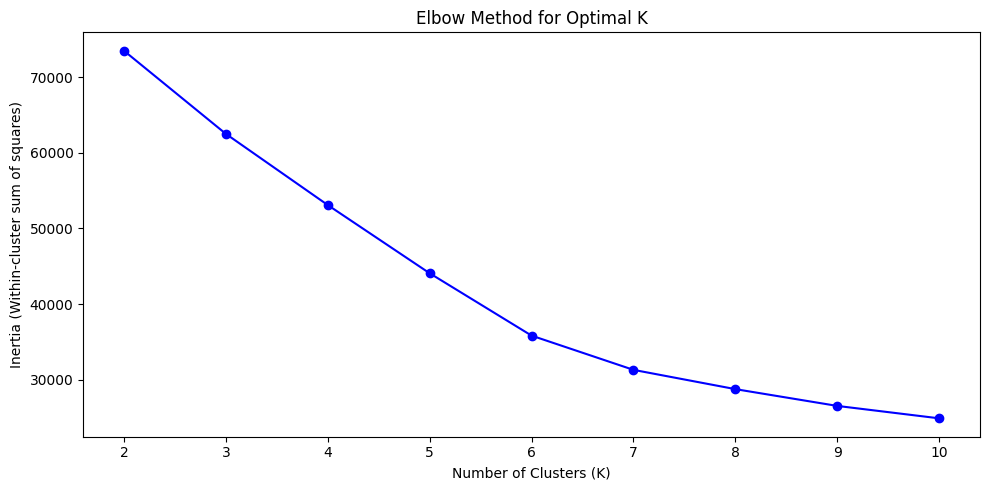

Tip: Look for the 'elbow' where inertia stops decreasing rapidly


In [28]:
# Find optimal K using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, inertias, 'bo-')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia (Within-cluster sum of squares)')
ax.set_title('Elbow Method for Optimal K')
ax.set_xticks(list(K_range))
plt.tight_layout()
plt.show()

print("Tip: Look for the 'elbow' where inertia stops decreasing rapidly")

In [29]:
# Run K-means with chosen K
N_CLUSTERS = 5  # Adjust based on elbow plot

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

# Count traders per cluster
cluster_counts = trader_features['cluster'].value_counts().sort_index()
print("Traders per cluster:")
for c, count in cluster_counts.items():
    print(f"  Cluster {c}: {count:,} traders ({count/len(trader_features)*100:.1f}%)")

Traders per cluster:
  Cluster 0: 2,961 traders (22.3%)
  Cluster 1: 3,032 traders (22.8%)
  Cluster 2: 7,190 traders (54.2%)
  Cluster 3: 91 traders (0.7%)
  Cluster 4: 2 traders (0.0%)


In [30]:
# Analyze cluster profiles
cluster_profiles = trader_features.groupby('cluster').agg({
    'user_address': 'count',
    'trade_count': 'median',
    'volume': 'median', 
    'coins_traded': 'median',
    'net_pnl': 'median',
    'avg_trade_size': 'median',
    'maker_pct': 'median',
    'win_rate': 'median',
    'pnl_per_volume_pct': 'median'
}).rename(columns={'user_address': 'count'})

# Format for display
cluster_profiles['volume'] = cluster_profiles['volume'].apply(lambda x: f"${x:,.0f}")
cluster_profiles['net_pnl'] = cluster_profiles['net_pnl'].apply(lambda x: f"${x:,.2f}")
cluster_profiles['avg_trade_size'] = cluster_profiles['avg_trade_size'].apply(lambda x: f"${x:,.0f}")
cluster_profiles['maker_pct'] = cluster_profiles['maker_pct'].apply(lambda x: f"{x:.1f}%")
cluster_profiles['win_rate'] = cluster_profiles['win_rate'].apply(lambda x: f"{x:.1f}%")
cluster_profiles['pnl_per_volume_pct'] = cluster_profiles['pnl_per_volume_pct'].apply(lambda x: f"{x:.3f}%")

print("Cluster Profiles (Median Values):")
cluster_profiles

Cluster Profiles (Median Values):


,count,trade_count,volume,coins_traded,net_pnl,avg_trade_size,maker_pct,win_rate,pnl_per_volume_pct
cluster,,,,,,,,,
0,2961,115.00,"$244,871",3.00,$-30.42,"$2,299",9.7%,44.5%,-0.029%
1,3032,13.00,$380,1.00,$1.14,$25,97.9%,61.5%,0.356%
2,7190,12.00,"$13,275",2.00,$-3.78,"$1,038",0.0%,33.3%,-0.066%
3,91,"1,428.00","$732,071",94.00,"$-8,189.77",$421,30.6%,38.1%,-0.916%
4,2,8.50,$38,15.50,$-615.67,$4,0.0%,0.0%,-1601.586%


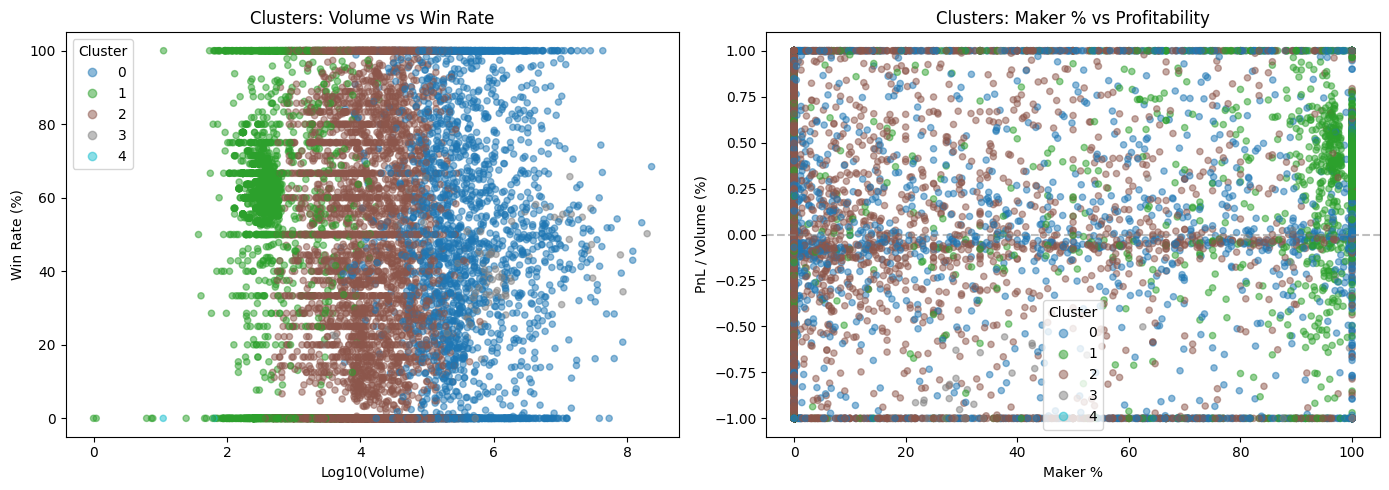

In [31]:
# Visualize clusters: Volume vs Win Rate, colored by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Volume vs Win Rate
colors = plt.cm.tab10(trader_features['cluster'])
ax1 = axes[0]
scatter = ax1.scatter(
    np.log10(trader_features['volume'].clip(lower=1)), 
    trader_features['win_rate'],
    c=trader_features['cluster'], 
    cmap='tab10', 
    alpha=0.5,
    s=20
)
ax1.set_xlabel('Log10(Volume)')
ax1.set_ylabel('Win Rate (%)')
ax1.set_title('Clusters: Volume vs Win Rate')
ax1.legend(*scatter.legend_elements(), title="Cluster")

# Plot 2: Maker % vs PnL/Volume
ax2 = axes[1]
scatter2 = ax2.scatter(
    trader_features['maker_pct'],
    trader_features['pnl_per_volume_pct'].clip(-1, 1),  # Clip outliers
    c=trader_features['cluster'],
    cmap='tab10',
    alpha=0.5,
    s=20
)
ax2.set_xlabel('Maker %')
ax2.set_ylabel('PnL / Volume (%)')
ax2.set_title('Clusters: Maker % vs Profitability')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.legend(*scatter2.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

In [32]:
# Name clusters based on characteristics
cluster_stats = trader_features.groupby('cluster').agg({
    'volume': 'median',
    'trade_count': 'median',
    'maker_pct': 'median',
    'win_rate': 'median',
    'net_pnl': 'median',
    'coins_traded': 'median'
})

def name_cluster(row):
    """Generate cluster name based on characteristics"""
    names = []
    
    # Volume tier
    if row['volume'] > 1_000_000:
        names.append("Whale")
    elif row['volume'] > 100_000:
        names.append("Large")
    elif row['volume'] > 10_000:
        names.append("Medium")
    else:
        names.append("Small")
    
    # Trading style
    if row['maker_pct'] > 70:
        names.append("Maker")
    elif row['maker_pct'] < 30:
        names.append("Taker")
    
    # Performance
    if row['win_rate'] > 60 and row['net_pnl'] > 0:
        names.append("Winner")
    elif row['win_rate'] < 40 or row['net_pnl'] < -100:
        names.append("Struggling")
    
    # Diversity
    if row['coins_traded'] > 10:
        names.append("Diversified")
    elif row['coins_traded'] <= 2:
        names.append("Focused")
    
    return " ".join(names) if names else "Standard"

cluster_names = cluster_stats.apply(name_cluster, axis=1).to_dict()
trader_features['cluster_name'] = trader_features['cluster'].map(cluster_names)

print("Cluster Names:")
for c, name in sorted(cluster_names.items()):
    count = (trader_features['cluster'] == c).sum()
    print(f"  Cluster {c}: {name} ({count:,} traders)")

Cluster Names:
  Cluster 0: Large Taker (2,961 traders)
  Cluster 1: Small Maker Winner Focused (3,032 traders)
  Cluster 2: Medium Taker Struggling Focused (7,190 traders)
  Cluster 3: Large Struggling Diversified (91 traders)
  Cluster 4: Small Taker Struggling Diversified (2 traders)


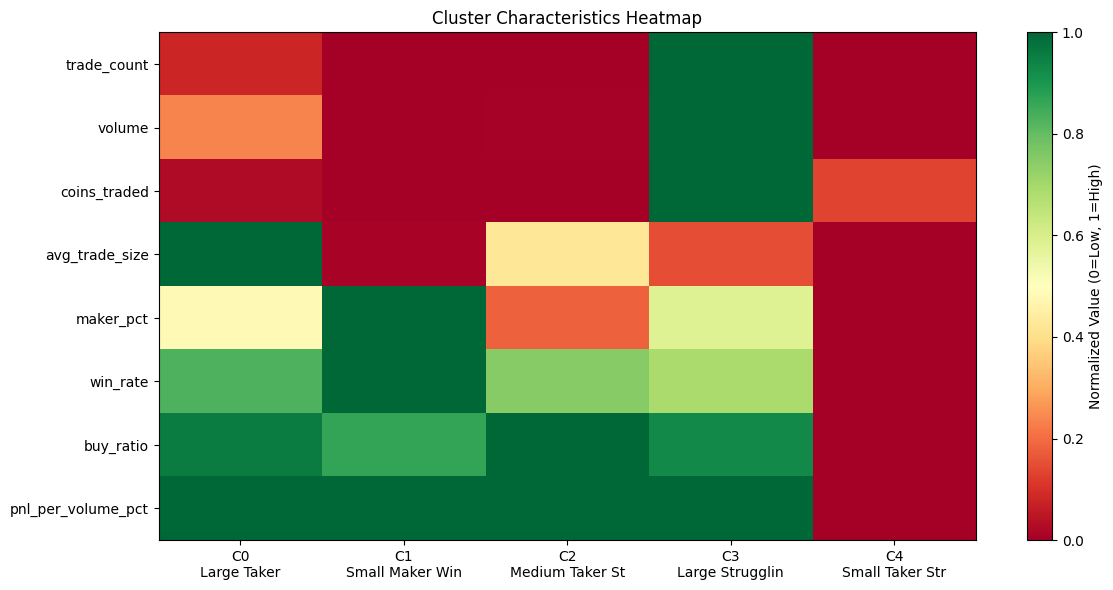

In [33]:
# Radar/spider chart of cluster characteristics (normalized)
from sklearn.preprocessing import MinMaxScaler

# Normalize cluster centers for comparison
cluster_means = trader_features.groupby('cluster')[feature_cols].mean()
scaler = MinMaxScaler()
cluster_normalized = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

# Heatmap of cluster characteristics
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(cluster_normalized.T, cmap='RdYlGn', aspect='auto')

# Labels
ax.set_xticks(range(len(cluster_normalized)))
ax.set_xticklabels([f"C{i}\n{cluster_names.get(i, '')[:15]}" for i in cluster_normalized.index])
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(feature_cols)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Value (0=Low, 1=High)')

ax.set_title('Cluster Characteristics Heatmap')
plt.tight_layout()
plt.show()

In [34]:
# Top traders from each cluster (by volume)
print("Top 3 Traders per Cluster (by volume):\n")
print("=" * 100)

for cluster_id in sorted(trader_features['cluster'].unique()):
    cluster_data = trader_features[trader_features['cluster'] == cluster_id]
    cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
    
    print(f"\n{cluster_name} (Cluster {cluster_id}) - {len(cluster_data):,} traders")
    print("-" * 100)
    
    top = cluster_data.nlargest(3, 'volume')[['user_address', 'volume', 'trade_count', 'net_pnl', 'win_rate', 'maker_pct']]
    top['volume'] = top['volume'].apply(lambda x: f"${x:,.0f}")
    top['net_pnl'] = top['net_pnl'].apply(lambda x: f"${x:,.2f}")
    top['win_rate'] = top['win_rate'].apply(lambda x: f"{x:.1f}%")
    top['maker_pct'] = top['maker_pct'].apply(lambda x: f"{x:.1f}%")
    
    print(top.to_string(index=False))

Top 3 Traders per Cluster (by volume):


Large Taker (Cluster 0) - 2,961 traders
----------------------------------------------------------------------------------------------------
                              user_address       volume  trade_count     net_pnl win_rate maker_pct
0xe3b6e3443c8f2080704e7421bad9340f13950acb $233,151,429         8523 $269,397.87    68.5%     38.4%
0xc6ac58a7a63339898aeda32499a8238a46d88e84 $166,014,048         7024 $-51,493.71    53.2%     20.6%
0x162cc7c861ebd0c06b3d72319201150482518185 $122,116,498        50976 $-88,294.84    45.4%     33.6%

Small Maker Winner Focused (Cluster 1) - 3,032 traders
----------------------------------------------------------------------------------------------------
                              user_address  volume  trade_count   net_pnl win_rate maker_pct
0xc7744f3ac65db9ecdd87a7787cacd90527dd422e $23,892           50    $30.04   100.0%     97.0%
0x89705863d752197e8d663555b91f0f068e46ecd5 $22,500           42 $2,882.49  

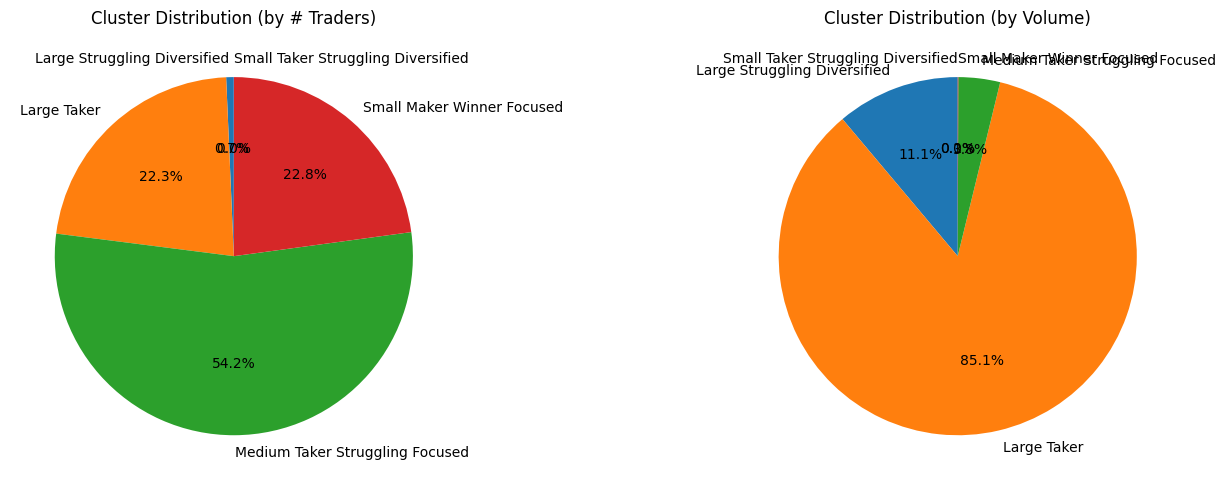


Cluster Summary:


,traders,volume,net_pnl,avg_volume,avg_pnl,volume_share
cluster_name,,,,,,
Large Struggling Diversified,91,"$646,607,067","$-3,103,164","$7,105,572","$-34,101",11.1%
Large Taker,2961,"$4,943,093,373","$6,333,216","$1,669,400","$2,139",85.1%
Medium Taker Struggling Focused,7190,"$218,573,270","$481,208","$30,400",$67,3.8%
Small Maker Winner Focused,3032,"$3,013,443","$16,266",$994,$5,0.1%
Small Taker Struggling Diversified,2,$75,"$-1,231",$38,$-616,0.0%


In [35]:
# Cluster composition: traders vs volume share
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie 1: Number of traders
trader_counts = trader_features.groupby('cluster_name').size()
axes[0].pie(trader_counts, labels=trader_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Cluster Distribution (by # Traders)')

# Pie 2: Volume share
volume_by_cluster = trader_features.groupby('cluster_name')['volume'].sum()
axes[1].pie(volume_by_cluster, labels=volume_by_cluster.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Cluster Distribution (by Volume)')

plt.tight_layout()
plt.show()

# Summary stats
print("\nCluster Summary:")
summary = trader_features.groupby('cluster_name').agg({
    'user_address': 'count',
    'volume': 'sum',
    'net_pnl': 'sum'
}).rename(columns={'user_address': 'traders'})
summary['avg_volume'] = summary['volume'] / summary['traders']
summary['avg_pnl'] = summary['net_pnl'] / summary['traders']
summary['volume_share'] = summary['volume'] / summary['volume'].sum() * 100

for col in ['volume', 'net_pnl', 'avg_volume', 'avg_pnl']:
    summary[col] = summary[col].apply(lambda x: f"${x:,.0f}")
summary['volume_share'] = summary['volume_share'].apply(lambda x: f"{x:.1f}%")

summary

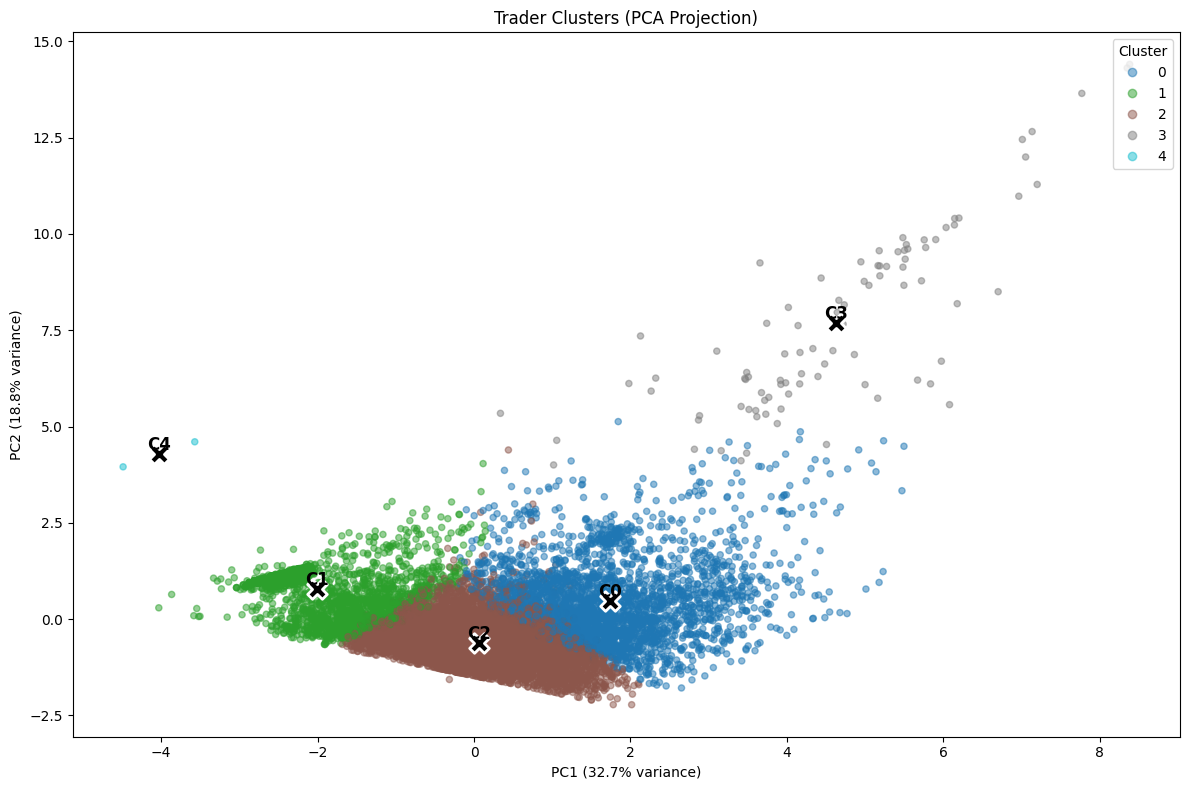


PCA explains 51.5% of variance in first 2 components


In [36]:
# PCA visualization - reduce to 2D for plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=trader_features['cluster'], 
                     cmap='tab10', 
                     alpha=0.5, 
                     s=20)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(centers_pca):
    ax.scatter(x, y, c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.annotate(f"C{i}", (x, y), fontsize=12, fontweight='bold', 
                ha='center', va='bottom', color='black')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('Trader Clusters (PCA Projection)')
ax.legend(*scatter.legend_elements(), title="Cluster", loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum()*100:.1f}% of variance in first 2 components")

---

## Practical Use Cases

How to use cluster analysis for trading insights.

### 1. Find "Smart Money" - Consistently Profitable Traders

Identify traders with edge worth studying or copy-trading.

In [37]:
# Smart Money: High win rate + profitable + enough trades for statistical significance
smart_money = trader_features[
    (trader_features['win_rate'] >= 60) &           # 60%+ win rate
    (trader_features['net_pnl'] > 1000) &           # $1k+ profit
    (trader_features['trade_count'] >= 20) &        # 20+ trades (statistical sig)
    (trader_features['pnl_per_volume_pct'] > 0.01)  # Positive edge
].sort_values('net_pnl', ascending=False)

print(f"Found {len(smart_money)} 'Smart Money' traders\n")
print("Top 10 Smart Money Traders:")
print("=" * 100)

display_cols = ['user_address', 'net_pnl', 'win_rate', 'trade_count', 'volume', 'maker_pct', 'coins_traded', 'cluster_name']
top_smart = smart_money.head(10)[display_cols].copy()
top_smart['net_pnl'] = top_smart['net_pnl'].apply(lambda x: f"${x:,.0f}")
top_smart['volume'] = top_smart['volume'].apply(lambda x: f"${x:,.0f}")
top_smart['win_rate'] = top_smart['win_rate'].apply(lambda x: f"{x:.0f}%")
top_smart['maker_pct'] = top_smart['maker_pct'].apply(lambda x: f"{x:.0f}%")
top_smart

Found 706 'Smart Money' traders

Top 10 Smart Money Traders:


,user_address,net_pnl,win_rate,trade_count,volume,maker_pct,coins_traded,cluster_name
5391,0x66362b929c1a9aaf14c51aab9b455ad7fb8268c4,"$989,917",74%,2391,"$40,440,278",39%,6,Large Taker
13173,0xfdcec78b3a783d677bad7b8d58823cea5b5d26c2,"$963,961",100%,373,"$9,080,293",25%,4,Large Taker
114,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,"$730,057",96%,719,"$12,031,885",58%,3,Large Taker
2772,0x34365f472a3af2ff8167970a519931437e2c2094,"$602,107",100%,433,"$8,107,811",13%,4,Large Taker
10105,0xc08b122fb1057149f55d49d3d5cea0d083b37ffb,"$516,930",100%,1315,"$298,441",2%,1,Large Taker
1425,0x1a67ea21ba0f895560590147203d08a832054055,"$458,387",100%,380,"$22,246,237",0%,1,Large Taker
1174,0x15271757b398cd1d3d7cca05c4f7b0c159afa7c2,"$435,750",100%,992,"$2,833,566",55%,2,Large Taker
6201,0x75d415edcb3c3782e5952470821e983f9053a209,"$405,304",100%,223,"$5,553,081",0%,1,Large Taker
12900,0xf83350f2426d9f4790b6aa61710f6a26ddd908e7,"$345,472",100%,772,"$8,102,168",23%,3,Large Taker
3307,0x3e9df9cc3f126532d495173932ad9522c071c508,"$313,058",100%,335,"$10,500,476",100%,1,Large Taker


In [38]:
# Deep dive: What coins does the top smart money trader trade?
if len(smart_money) > 0:
    SMART_TRADER = smart_money.iloc[0]['user_address']
    print(f"Analyzing top smart money trader: {SMART_TRADER[:20]}...\n")
    
    # Their coin preferences
    smart_trader_coins = query(f"""
    SELECT 
        coin,
        COUNT(*) / 2 AS trades,
        SUM(px::numeric * sz::numeric) / 2 AS volume,
        SUM(closed_pnl::numeric) AS pnl,
        AVG(CASE WHEN closed_pnl::numeric > 0 THEN 1 ELSE 0 END) * 100 AS win_rate
    FROM fills
    WHERE user_address = '{SMART_TRADER}'
      AND dir LIKE 'Close%'
    GROUP BY coin
    ORDER BY pnl DESC
    """)
    
    # Convert decimal columns to float
    for col in ['volume', 'pnl', 'win_rate']:
        if col in smart_trader_coins.columns:
            smart_trader_coins[col] = smart_trader_coins[col].astype(float)
    
    print("Their most profitable coins:")
    smart_trader_coins.head(10)

Analyzing top smart money trader: 0x66362b929c1a9aaf14...

Their most profitable coins:


### 2. Whale Tracking - Large Position Movers

Monitor whales who can move markets. Trade with them or fade them.

In [39]:
# Whales: Top 1% by volume
volume_threshold = trader_features['volume'].quantile(0.99)
whales = trader_features[trader_features['volume'] >= volume_threshold].sort_values('volume', ascending=False)

print(f"Whale threshold (top 1%): ${volume_threshold:,.0f} volume")
print(f"Found {len(whales)} whales\n")

# Whale summary
whale_summary = whales[['user_address', 'volume', 'trade_count', 'net_pnl', 'maker_pct', 'coins_traded', 'cluster_name']].copy()
whale_summary['volume'] = whale_summary['volume'].apply(lambda x: f"${x:,.0f}")
whale_summary['net_pnl'] = whale_summary['net_pnl'].apply(lambda x: f"${x:,.0f}")
whale_summary['maker_pct'] = whale_summary['maker_pct'].apply(lambda x: f"{x:.0f}%")

print("Top 15 Whales:")
whale_summary.head(15)

Whale threshold (top 1%): $7,457,250 volume
Found 133 whales

Top 15 Whales:


,user_address,volume,trade_count,net_pnl,maker_pct,coins_traded,cluster_name
11877,0xe3b6e3443c8f2080704e7421bad9340f13950acb,"$233,151,429",8523,"$269,398",38%,1,Large Taker
4621,0x57dd78cd36e76e2011e8f6dc25cabbaba994494b,"$200,092,603",24333,"$161,281",96%,49,Large Struggling Diversified
10422,0xc6ac58a7a63339898aeda32499a8238a46d88e84,"$166,014,048",7024,"$-51,494",21%,1,Large Taker
1227,0x162cc7c861ebd0c06b3d72319201150482518185,"$122,116,498",50976,"$-88,295",34%,17,Large Taker
12956,0xf9109ada2f73c62e9889b45453065f0d99260a2d,"$121,544,489",22848,"$-265,320",87%,33,Large Taker
12330,0xecb63caa47c7c4e77f60f1ce858cf28dc2b82b00,"$86,966,854",40854,"$-1,390,011",88%,52,Large Struggling Diversified
11388,0xd911e53d53b663972254e086450fd6198a25961e,"$86,207,248",1726,"$-169,911",67%,1,Large Taker
12700,0xf3e16a28b09be3836e66f091613c230128141fc1,"$81,903,654",4580,"$-144,525",0%,4,Large Taker
126,0x023a3d058020fb76cca98f01b3c48c8938a22355,"$79,534,595",19787,"$-491,403",100%,65,Large Struggling Diversified
7507,0x8e80c4b533dd977cf716b5c24fd9223129272804,"$71,031,406",5177,"$48,490",96%,18,Large Taker


In [40]:
# What are whales trading right now? Recent whale activity
whale_addresses = whales['user_address'].tolist()
whale_list = "', '".join(whale_addresses[:50])  # Top 50 whales

recent_whale_activity = query(f"""
SELECT 
    coin,
    SUM(CASE WHEN side = 'B' THEN sz::numeric ELSE 0 END) AS buy_size,
    SUM(CASE WHEN side = 'A' THEN sz::numeric ELSE 0 END) AS sell_size,
    SUM(CASE WHEN side = 'B' THEN sz::numeric ELSE -sz::numeric END) AS net_size,
    SUM(px::numeric * sz::numeric) AS volume,
    COUNT(DISTINCT user_address) AS whale_count
FROM fills
WHERE user_address IN ('{whale_list}')
GROUP BY coin
HAVING SUM(px::numeric * sz::numeric) > 100000
ORDER BY ABS(SUM(CASE WHEN side = 'B' THEN sz::numeric ELSE -sz::numeric END)) DESC
LIMIT 15
""")

# Convert decimal columns to float
for col in ['buy_size', 'sell_size', 'net_size', 'volume']:
    if col in recent_whale_activity.columns:
        recent_whale_activity[col] = recent_whale_activity[col].astype(float)

print("Whale Activity by Coin (sorted by net position change):")
print("Positive net = whales buying, Negative net = whales selling\n")
recent_whale_activity

Whale Activity by Coin (sorted by net position change):
Positive net = whales buying, Negative net = whales selling



,coin,buy_size,sell_size,net_size,volume,whale_count
0,kPEPE,"2,229,840,591.00","2,802,433,935.00","-572,593,344.00","64,154,148.48",23
1,@188,"2,119,264,947.00","2,259,025,827.00","-139,760,880.00","11,865,337.34",4
2,PUMP,"5,298,655,243.00","5,437,761,008.00","-139,105,765.00","29,105,437.03",14
3,PENGU,"505,536,739.00","575,349,191.00","-69,812,452.00","47,285,301.38",15
4,DOGE,"89,209,585.00","109,043,626.00","-19,834,041.00","47,409,604.45",21
5,kSHIB,"58,520,317.00","64,024,593.00","-5,504,276.00","1,723,713.00",8
6,REZ,"9,518,401.00","14,537,483.00","-5,019,082.00","350,556.26",3
7,GALA,"12,488,801.00","17,066,365.00","-4,577,564.00","531,573.72",7
8,BLAST,"52,471,520.00","56,809,179.00","-4,337,659.00","375,449.92",3
9,BOME,"42,288,627.00","38,039,937.00","4,248,690.00","172,317.45",4


### 3. Market Maker Identification

Find liquidity providers - useful for understanding market structure and spreads.

In [41]:
# Market Makers: High maker %, high volume, many trades
market_makers = trader_features[
    (trader_features['maker_pct'] >= 80) &         # 80%+ maker
    (trader_features['volume'] >= 100_000) &       # $100k+ volume
    (trader_features['trade_count'] >= 50)         # Active
].sort_values('volume', ascending=False)

print(f"Found {len(market_makers)} likely market makers\n")

# Are MMs profitable?
mm_profitable = (market_makers['net_pnl'] > 0).sum()
print(f"Profitable MMs: {mm_profitable}/{len(market_makers)} ({mm_profitable/len(market_makers)*100:.0f}%)")
print(f"Total MM volume: ${market_makers['volume'].sum():,.0f}")
print(f"Total MM PnL: ${market_makers['net_pnl'].sum():,.0f}\n")

# Top market makers
mm_display = market_makers[['user_address', 'volume', 'trade_count', 'net_pnl', 'maker_pct', 'win_rate', 'coins_traded']].head(10).copy()
mm_display['volume'] = mm_display['volume'].apply(lambda x: f"${x:,.0f}")
mm_display['net_pnl'] = mm_display['net_pnl'].apply(lambda x: f"${x:,.0f}")
mm_display['maker_pct'] = mm_display['maker_pct'].apply(lambda x: f"{x:.0f}%")
mm_display['win_rate'] = mm_display['win_rate'].apply(lambda x: f"{x:.0f}%")

print("Top 10 Market Makers:")
mm_display

Found 368 likely market makers

Profitable MMs: 170/368 (46%)
Total MM volume: $1,937,841,819
Total MM PnL: $-2,094,969

Top 10 Market Makers:


,user_address,volume,trade_count,net_pnl,maker_pct,win_rate,coins_traded
4621,0x57dd78cd36e76e2011e8f6dc25cabbaba994494b,"$200,092,603",24333,"$161,281",96%,50%,49
12956,0xf9109ada2f73c62e9889b45453065f0d99260a2d,"$121,544,489",22848,"$-265,320",87%,43%,33
12330,0xecb63caa47c7c4e77f60f1ce858cf28dc2b82b00,"$86,966,854",40854,"$-1,390,011",88%,34%,52
126,0x023a3d058020fb76cca98f01b3c48c8938a22355,"$79,534,595",19787,"$-491,403",100%,44%,65
7507,0x8e80c4b533dd977cf716b5c24fd9223129272804,"$71,031,406",5177,"$48,490",96%,54%,18
9726,0xb8eb97eaed8367079894d2f1bed69bd220ec1dd5,"$64,084,401",1335,"$-212,956",100%,28%,1
6510,0x7b7f72a28fe109fa703eeed7984f2a8a68fedee2,"$57,642,445",4076,"$123,402",100%,52%,5
6328,0x7839e2f2c375dd2935193f2736167514efff9916,"$38,805,110",12104,"$-3,956",100%,41%,8
10697,0xcb92c5988b1d4f145a7b481690051f03ead23a13,"$38,438,843",1392,"$-16,746",89%,0%,1
3911,0x49ba9baa20d355ba042af2be9772d2b2cd892f44,"$35,756,236",2081,$885,82%,36%,4


### 4. Counter-Trade Candidates ("Inverse" Signals)

Find consistently losing traders - their trades may be useful inverse signals.

In [42]:
# Inverse signals: Consistently losing traders with enough volume to matter
inverse_candidates = trader_features[
    (trader_features['win_rate'] <= 35) &           # Low win rate
    (trader_features['net_pnl'] < -500) &           # Significant losses
    (trader_features['trade_count'] >= 30) &        # Enough trades
    (trader_features['volume'] >= 50_000)           # Meaningful volume
].sort_values('net_pnl', ascending=True)

print(f"Found {len(inverse_candidates)} consistent losers (potential inverse signals)\n")

# Their aggregate stats
if len(inverse_candidates) > 0:
    print(f"Combined losses: ${inverse_candidates['net_pnl'].sum():,.0f}")
    print(f"Average win rate: {inverse_candidates['win_rate'].mean():.1f}%")
    print(f"Average PnL/Volume: {inverse_candidates['pnl_per_volume_pct'].mean():.3f}%\n")

    inv_display = inverse_candidates[['user_address', 'net_pnl', 'win_rate', 'trade_count', 'volume', 'coins_traded']].head(10).copy()
    inv_display['net_pnl'] = inv_display['net_pnl'].apply(lambda x: f"${x:,.0f}")
    inv_display['volume'] = inv_display['volume'].apply(lambda x: f"${x:,.0f}")
    inv_display['win_rate'] = inv_display['win_rate'].apply(lambda x: f"{x:.0f}%")
    
    print("Top 10 Inverse Signal Candidates:")
    display(inv_display)

Found 719 consistent losers (potential inverse signals)

Combined losses: $-14,814,344
Average win rate: 11.0%
Average PnL/Volume: -3.073%

Top 10 Inverse Signal Candidates:


,user_address,net_pnl,win_rate,trade_count,volume,coins_traded
8050,0x985f02b19dbc062e565c981aac5614baf2cf501f,"$-2,300,833",14%,2415,"$6,904,034",8
12330,0xecb63caa47c7c4e77f60f1ce858cf28dc2b82b00,"$-1,390,011",34%,40854,"$86,966,854",52
8794,0xa6e2dc44418f5ad213c86db4dbb203a59d13c49f,"$-726,008",19%,4296,"$8,293,387",17
7114,0x875d24a727a186bd73d87cc8851f5b4526f70d09,"$-592,071",0%,1973,"$53,878,222",2
8618,0xa31441e058492bc7cfffda9aa7623c407ae83a81,"$-556,084",2%,1725,"$2,847,704",9
5034,0x5f7e1de048ba1f23f60b1455849eebfce4a6b441,"$-418,629",0%,720,"$3,505,693",2
7438,0x8d561a78bff637971c20c2640653eac790707480,"$-335,996",0%,35,"$2,091,106",1
2635,0x319d046ac361ac2fbe89518c62daa42f4073dc82,"$-278,087",0%,39,"$98,694",1
9951,0xbd9c944dcfb31cd24c81ebf1c974d950f44e42b8,"$-239,588",21%,552,"$2,768,875",8
9726,0xb8eb97eaed8367079894d2f1bed69bd220ec1dd5,"$-212,956",28%,1335,"$64,084,401",1


### 5. Coin Specialists

Find traders who are particularly skilled at specific coins.

In [43]:
# Find the best traders for each major coin
COINS_TO_ANALYZE = ['BTC', 'ETH', 'SOL', 'HYPE']  # Add coins of interest

coin_specialists = query(f"""
WITH coin_traders AS (
    SELECT 
        user_address,
        coin,
        COUNT(*) / 2 AS trades,
        SUM(px::numeric * sz::numeric) / 2 AS volume,
        SUM(closed_pnl::numeric) AS pnl,
        SUM(CASE WHEN closed_pnl::numeric > 0 THEN 1 ELSE 0 END)::float / 
            NULLIF(COUNT(*) FILTER (WHERE dir LIKE 'Close%'), 0) * 100 AS win_rate
    FROM fills
    WHERE coin IN ('{"', '".join(COINS_TO_ANALYZE)}')
    GROUP BY user_address, coin
    HAVING COUNT(*) >= 20  -- Min 20 fills
)
SELECT 
    coin,
    user_address,
    trades,
    volume,
    pnl,
    win_rate
FROM coin_traders
WHERE pnl > 0
ORDER BY coin, pnl DESC
""")

# Convert decimal columns to float
for col in ['volume', 'pnl', 'win_rate']:
    if col in coin_specialists.columns:
        coin_specialists[col] = coin_specialists[col].astype(float)

print("Top 5 Traders per Coin:\n")
for coin in COINS_TO_ANALYZE:
    coin_data = coin_specialists[coin_specialists['coin'] == coin].head(5)
    if len(coin_data) > 0:
        print(f"=== {coin} ===")
        for _, row in coin_data.iterrows():
            print(f"  {row['user_address'][:20]}... | PnL: ${row['pnl']:,.0f} | Win: {row['win_rate']:.0f}% | Trades: {row['trades']}")
        print()

Top 5 Traders per Coin:

=== BTC ===
  0x34365f472a3af2ff81... | PnL: $391,711 | Win: 100% | Trades: 168
  0x66362b929c1a9aaf14... | PnL: $374,357 | Win: 100% | Trades: 1062
  0xf07fa5f5a652c2c970... | PnL: $188,732 | Win: 100% | Trades: 44
  0x2615482299998de7db... | PnL: $129,513 | Win: 100% | Trades: 468
  0x7fe8cfe481ec2f7026... | PnL: $123,906 | Win: 100% | Trades: 69

=== ETH ===
  0xfdcec78b3a783d677b... | PnL: $967,199 | Win: 100% | Trades: 77
  0x2ba553d9f990a3b66b... | PnL: $827,193 | Win: 100% | Trades: 653
  0x020ca66c30bec2c4fe... | PnL: $718,996 | Win: 100% | Trades: 528
  0x66362b929c1a9aaf14... | PnL: $602,408 | Win: 93% | Trades: 163
  0x1a67ea21ba0f895560... | PnL: $470,845 | Win: 100% | Trades: 380

=== SOL ===
  0x2ef766eeede7bf60e7... | PnL: $83,913 | Win: 100% | Trades: 499
  0x788def0b754265c43c... | PnL: $62,048 | Win: 64% | Trades: 228
  0xfbf3bc0131f4f396fe... | PnL: $43,201 | Win: 100% | Trades: 446
  0x508e08d49decd97cc3... | PnL: $40,607 | Win: 100% | Trade

### 6. Build a Watchlist

Create a curated list of traders to monitor.

In [44]:
# Build a comprehensive watchlist
watchlist = pd.DataFrame()

# Add smart money (top 20)
if len(smart_money) > 0:
    sm = smart_money.head(20).copy()
    sm['category'] = 'Smart Money'
    watchlist = pd.concat([watchlist, sm])

# Add whales (top 20)  
if len(whales) > 0:
    wh = whales.head(20).copy()
    wh['category'] = 'Whale'
    watchlist = pd.concat([watchlist, wh])

# Add market makers (top 10)
if len(market_makers) > 0:
    mm = market_makers.head(10).copy()
    mm['category'] = 'Market Maker'
    watchlist = pd.concat([watchlist, mm])

# Remove duplicates (keep first category)
watchlist = watchlist.drop_duplicates(subset='user_address', keep='first')

print(f"Watchlist: {len(watchlist)} unique traders\n")
print("Breakdown:")
print(watchlist['category'].value_counts())

# Export to CSV
watchlist_export = watchlist[['user_address', 'category', 'volume', 'net_pnl', 'win_rate', 'maker_pct', 'trade_count', 'cluster_name']]
watchlist_export.to_csv('../data/watchlist.csv', index=False)
print(f"\nExported to data/watchlist.csv")

Watchlist: 40 unique traders

Breakdown:
category
Smart Money     20
Whale           17
Market Maker     3
Name: count, dtype: int64

Exported to data/watchlist.csv


---

## Summary: How to Use This Analysis

| Use Case | What to Look For | Action |
|----------|------------------|--------|
| **Copy Trading** | Smart money with high win rate + consistent profits | Follow their trades on the same coins |
| **Whale Tracking** | Large volume traders' net positioning | Trade with momentum or fade extremes |
| **Market Making** | Identify MM activity on specific coins | Understand liquidity, avoid competing |
| **Inverse Signals** | Consistent losers | Consider opposite positions |
| **Coin Alpha** | Specialists with edge on specific coins | Focus on their preferred coins |
| **Risk Management** | Cluster analysis | Know what type of traders you're competing against |

### Next Steps

1. **Real-time monitoring**: Set up alerts when watchlist traders open positions
2. **Backtesting**: Test if following smart money historically generates alpha
3. **Position sizing**: Weight signals by trader's historical accuracy
4. **Multi-day analysis**: Load more data to find persistent edge vs luck